In [11]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import csv
import os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import optimizers
from keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
print ("Tensorflow version:", tf.__version__)
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.metrics import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
import time
import scipy
from scipy import ndimage
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
import splitfolders
logging.getLogger("tensorflow").setLevel(logging.ERROR)
np.random.seed(123)
print ('modules loaded')

Tensorflow version: 2.8.0
modules loaded


## *Data Pre-Processing*

#### The Data for this project can be downloaded [here](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=52758223)

### The data for this project was acquired in three parts:

> #### 1) A training set separated into 3 directories, each with separate class labeled directories
> #### 2) A validation set with all images in the same directory and a CSV file with filenames and class labels
> #### 3) A test set with no class labels

- #### We will combine all the data of the training and validation sets into labeled directories and split the whole into training, validation, and test sets for use in this project.

- #### We will re-name the provided test set and to "unlabeled" and reserve it for demonstration purposes, as there is no way of knowing if the predicitions are correct and how a partivular model is performing with it.

### Training Data:

In [2]:
# Set paths of 3x2 pre-labeled directories
f0_data_training_ALL_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_0/all/'
f0_data_training_Normal_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_0/hem/'

f1_data_training_ALL_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_1/all/'
f1_data_training_Normal_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_1/hem/'

f2_data_training_ALL_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_2/all/'
f2_data_training_Normal_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_training_data/fold_2/hem/'

# Create lists of all ALL images in these directories
f0_imgs_ALL = [file for file in os.listdir(f0_data_training_ALL_dir) if file.endswith('.bmp')]
f1_imgs_ALL = [file for file in os.listdir(f1_data_training_ALL_dir) if file.endswith('.bmp')]
f2_imgs_ALL = [file for file in os.listdir(f2_data_training_ALL_dir) if file.endswith('.bmp')]

# Create lists of all Normal images in these directories
f0_imgs_Normal = [file for file in os.listdir(f0_data_training_Normal_dir) if file.endswith('.bmp')]
f1_imgs_Normal = [file for file in os.listdir(f1_data_training_Normal_dir) if file.endswith('.bmp')]
f2_imgs_Normal = [file for file in os.listdir(f2_data_training_Normal_dir) if file.endswith('.bmp')]


### Validation Data

In [3]:
# Set paths of directory
data_val_dir = 'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_test_prelim_phase_data/'

# Read in and inspect the dataframe with the filenames and labels
val_df = pd.read_csv('data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data_labels.csv')

val_df.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [4]:
# Change labels to use "binary" class_mode
val_df = val_df.replace({'labels':{0 : 'ALL', 1 : 'Normal'}})

# filenames do not use 'Patient_ID', so drop the column
val_df = val_df.drop('Patient_ID', axis=1)

val_df.head()

,new_names,labels
0,1.bmp,Normal
1,2.bmp,Normal
2,3.bmp,Normal
3,4.bmp,ALL
4,5.bmp,Normal


In [5]:
# Group the the df by labels so we can split them
val_split_df = val_df.groupby('labels')

# Split the filenames into separate df's and create lists of them
val_ALL_df = val_split_df.get_group('ALL')
val_images_ALL = [img for img in val_ALL_df.new_names]

val_Normal_df = val_split_df.get_group('Normal')
val_images_Normal = [img for img in val_Normal_df.new_names]

In [6]:
val_ALL_df.head()

,new_names,labels
3,4.bmp,ALL
6,7.bmp,ALL
7,8.bmp,ALL
12,13.bmp,ALL
13,14.bmp,ALL


In [7]:
val_images_ALL[:5]

['4.bmp', '7.bmp', '8.bmp', '13.bmp', '14.bmp']

In [8]:
val_Normal_df.head()

,new_names,labels
0,1.bmp,Normal
1,2.bmp,Normal
2,3.bmp,Normal
4,5.bmp,Normal
5,6.bmp,Normal


In [9]:
val_images_Normal[:5]

['1.bmp', '2.bmp', '3.bmp', '5.bmp', '6.bmp']

### Combine the data into one directory

In [10]:
# Set new directory path for all images to be combined
new_dir = 'data/labeled_images/'
combo_ALL_dir = os.path.join(new_dir, 'ALL')
combo_Normal_dir = os.path.join(new_dir, 'Normal')

# Create the new directory
os.mkdir(new_dir)
os.mkdir(combo_ALL_dir)
os.mkdir(combo_Normal_dir)

In [11]:
#  Move images from training_data directories:

# ALL
for img in f0_imgs_ALL:
    origin = os.path.join(f0_data_training_ALL_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)
    
for img in f1_imgs_ALL:
    origin = os.path.join(f1_data_training_ALL_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)
    
for img in f2_imgs_ALL:
    origin = os.path.join(f2_data_training_ALL_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)
    
# Normal
for img in f0_imgs_Normal:
    origin = os.path.join(f0_data_training_Normal_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)
    
for img in f1_imgs_Normal:
    origin = os.path.join(f1_data_training_Normal_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)
    
for img in f2_imgs_Normal:
    origin = os.path.join(f2_data_training_Normal_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)

In [12]:
#  Move images from validation_data directory:

# ALL
for img in val_images_ALL:
    origin = os.path.join(data_val_dir, img)
    destination = os.path.join(combo_ALL_dir, img)
    os.rename(origin, destination)

# Normal
for img in val_images_Normal:
    origin = os.path.join(data_val_dir, img)
    destination = os.path.join(combo_Normal_dir, img)
    os.rename(origin, destination)


In [13]:
total = len(os.listdir(combo_ALL_dir)) + len(os.listdir(combo_Normal_dir))
print('There are', len(os.listdir(combo_ALL_dir)) + len(os.listdir(combo_Normal_dir)), 'total images')
print("--------------------------------")
print('There are', len(os.listdir(combo_ALL_dir)), 'ALL cell images')
print('There are', len(os.listdir(combo_Normal_dir)), 'Normal cell images')


There are 12528 total images
--------------------------------
There are 7920 ALL cell images
There are 4608 Normal cell images


### Split the data into training, validation, and test sets
>### Training   ~ 80%
>### Validation ~ 19%
>### Test       ~ 1%

In [14]:
# Create new directory for the training, validation, and testing datasets
tvt_dir = 'data/tvt/'
os.mkdir(tvt_dir)

# Create paths for new dirctory datasets and class label folders
train_folder = os.path.join(tvt_dir, 'train')
train_ALL = os.path.join(train_folder, 'ALL')
train_Normal = os.path.join(train_folder, 'Normal')

val_folder = os.path.join(tvt_dir, 'validation')
val_ALL = os.path.join(val_folder, 'ALL')
val_Normal = os.path.join(val_folder, 'Normal')

test_folder = os.path.join(tvt_dir, 'test')
test_ALL = os.path.join(test_folder, 'ALL')
test_Normal = os.path.join(test_folder, 'Normal')

# Create the class label folders
os.mkdir(train_folder)
os.mkdir(train_ALL)
os.mkdir(train_Normal)

os.mkdir(val_folder)
os.mkdir(val_ALL)
os.mkdir(val_Normal)

os.mkdir(test_folder)
os.mkdir(test_ALL)
os.mkdir(test_Normal)

In [15]:
# do the math for our splits
print('There are', len(os.listdir(combo_ALL_dir)) + len(os.listdir(combo_Normal_dir)), 'total images')
print("--------------------------------")
print('There are', len(os.listdir(combo_ALL_dir)), 'ALL cell images')
print('There are', len(os.listdir(combo_Normal_dir)), 'Normal cell images')

train_ALL_total = (len(os.listdir(combo_ALL_dir))) * 0.80
train_Normal_total = (len(os.listdir(combo_Normal_dir))) * 0.80

val_ALL_total = (len(os.listdir(combo_ALL_dir))) * 0.19
val_Normal_total = (len(os.listdir(combo_Normal_dir))) * 0.19
               
test_ALL_total = (len(os.listdir(combo_ALL_dir))) * 0.01
test_Normal_total = (len(os.listdir(combo_Normal_dir))) * 0.01
print("--------------------------------")
print("--------------------------------")
print("Train ALL        :", round(train_ALL_total,2), "  :", )
print("Train Normal     :", round(train_Normal_total,2), "  :", )
print("--------------------------------")
print("Validation ALL   :", round(val_ALL_total,2),   "  :", val_ALL_total+train_ALL_total)
print("Validation Nomral:", round(val_Normal_total,2),   "  :", val_Normal_total+train_Normal_total)
print("--------------------------------")
print("Test ALL         :", round(test_ALL_total,2),  "    :", val_ALL_total+train_ALL_total+test_ALL_total)
print("Test Normal      :", round(test_Normal_total,2),  "   :", val_Normal_total+train_Normal_total+test_Normal_total)

There are 12528 total images
--------------------------------
There are 7920 ALL cell images
There are 4608 Normal cell images
--------------------------------
--------------------------------
Train ALL        : 6336.0   :
Train Normal     : 3686.4   :
--------------------------------
Validation ALL   : 1504.8   : 7840.8
Validation Nomral: 875.52   : 4561.92
--------------------------------
Test ALL         : 79.2     : 7920.0
Test Normal      : 46.08    : 4608.0


### Create the Splits

In [16]:
# Create iterables
imgs_ALL = [img for img in os.listdir(combo_ALL_dir)]
imgs_Normal = [img for img in os.listdir(combo_Normal_dir)]

# train ALL
imgs = imgs_ALL[:6337]
for img in imgs:
    origin = os.path.join(combo_ALL_dir, img)
    destination = os.path.join(train_ALL, img)
    shutil.copyfile(origin, destination)
    
# validation ALL
imgs = imgs_ALL[6337:7841]
for img in imgs:
    origin = os.path.join(combo_ALL_dir, img)
    destination = os.path.join(val_ALL, img)
    shutil.copyfile(origin, destination)

# test ALL
imgs = imgs_ALL[7841:]
for img in imgs:
    origin = os.path.join(combo_ALL_dir, img)
    destination = os.path.join(test_ALL, img)
    shutil.copyfile(origin, destination)
    
# train Normal
imgs = imgs_Normal[:3687]
for img in imgs:
    origin = os.path.join(combo_Normal_dir, img)
    destination = os.path.join(train_Normal, img)
    shutil.copyfile(origin, destination)

# validation Normal
imgs = imgs_Normal[3687:4562]
for img in imgs:
    origin = os.path.join(combo_Normal_dir, img)
    destination = os.path.join(val_Normal, img)
    shutil.copyfile(origin, destination)
    
# test Normal
imgs = imgs_Normal[4562:]
for img in imgs:
    origin = os.path.join(combo_Normal_dir, img)
    destination = os.path.join(test_Normal, img)
    shutil.copyfile(origin, destination)

In [17]:
# Reserve unlabeled data
origin_path =  'data/PKG - C-NMC_Leukemia/C-NMC_Leukemia/C-NMC_test_final_phase_data/'
destination_path = 'data/unlabeled_images/'
os.mkdir(destination_path)

unlabeled_images = [img for img in os.listdir(origin_path)]

# Move unlabeled images to the new directory
for img in unlabeled_images:
    origin = os.path.join(origin_path, img)
    destination = os.path.join(destination_path, img)
    os.rename(origin, destination)

In [18]:
#Remove unnecessary directories from the 'data' file
shutil.rmtree('data/PKG - C-NMC_Leukemia/')

# Build a baseline model

In [19]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/train',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size=10024)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/validation',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size = 2379)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/test',
        classes={'Normal':0, 'ALL':1},        
        class_mode='binary',
        batch_size = 125)

Found 10024 images belonging to 2 classes.
Found 2379 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [20]:
train_generator.class_indices

{'Normal': 0, 'ALL': 1}

In [21]:
val_generator.class_indices

{'Normal': 0, 'ALL': 1}

In [22]:
test_generator.class_indices

{'Normal': 0, 'ALL': 1}

In [23]:
# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 10024
Number of testing samples: 125
Number of validation samples: 2379
train_images shape: (10024, 256, 256, 3)
train_labels shape: (10024,)
test_images shape: (125, 256, 256, 3)
test_labels shape: (125,)
val_images shape: (2379, 256, 256, 3)
val_labels shape: (2379,)


In [24]:
#  Un-row the image matrices for modeling
train_x = train_images.reshape(train_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)

(10024, 196608)
(125, 196608)
(2379, 196608)


In [5]:
# The datasets is imbalanced so we will define class_weights to use for training
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes
                                                 )

train_class_weights = dict(enumerate(class_weights))

In [6]:
train_class_weights

{0: 1.3593707621372388, 1: 0.7909105254852454}

In [27]:
# Build the model and add layers
baseline_model = models.Sequential()

baseline_model.add(layers.Dense(16, activation='relu', input_shape=(196608,)))
baseline_model.add(layers.Dense(32, activation='relu'))

# Output layer
baseline_model.add(layers.Dense(1, activation='sigmoid'))

2022-03-02 11:08:33.007767: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
# Compile and fit the model to train
baseline_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

baseline_history = baseline_model.fit(train_x,
                                        train_labels,
                                        epochs=150,
                                        batch_size=512,
                                        validation_data=(val_x, val_labels),
                                        class_weight=train_class_weights,)

Epoch 1/150
20/20 [==============================] - 4s 149ms/step - loss: 0.6136 - accuracy: 0.6994 - val_loss: 0.5975 - val_accuracy: 0.6999
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5912 - accuracy: 0.7178 - val_loss: 0.5925 - val_accuracy: 0.6986
Epoch 3/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5846 - accuracy: 0.7181 - val_loss: 0.5958 - val_accuracy: 0.6936
Epoch 4/150
20/20 [==============================] - 3s 137ms/step - loss: 0.5808 - accuracy: 0.7204 - val_loss: 0.6051 - val_accuracy: 0.6843
Epoch 5/150
20/20 [==============================] - 3s 140ms/step - loss: 0.5754 - accuracy: 0.7261 - val_loss: 0.5897 - val_accuracy: 0.7011
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.5717 - accuracy: 0.7266 - val_loss: 0.5675 - val_accuracy: 0.7243
Epoch 7/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5719 - accuracy: 0.7266 - val_loss: 0.5636 - val_accuracy: 0.7230

Epoch 58/150
20/20 [==============================] - 3s 139ms/step - loss: 0.4083 - accuracy: 0.8284 - val_loss: 0.5651 - val_accuracy: 0.7301
Epoch 59/150
20/20 [==============================] - 3s 137ms/step - loss: 0.4063 - accuracy: 0.8317 - val_loss: 0.5781 - val_accuracy: 0.7150
Epoch 60/150
20/20 [==============================] - 3s 139ms/step - loss: 0.4058 - accuracy: 0.8234 - val_loss: 0.5635 - val_accuracy: 0.7259
Epoch 61/150
20/20 [==============================] - 3s 134ms/step - loss: 0.4048 - accuracy: 0.8276 - val_loss: 0.5421 - val_accuracy: 0.7520
Epoch 62/150
20/20 [==============================] - 3s 137ms/step - loss: 0.4032 - accuracy: 0.8290 - val_loss: 0.5613 - val_accuracy: 0.7306
Epoch 63/150
20/20 [==============================] - 3s 137ms/step - loss: 0.3965 - accuracy: 0.8324 - val_loss: 0.5801 - val_accuracy: 0.7184
Epoch 64/150
20/20 [==============================] - 3s 137ms/step - loss: 0.4010 - accuracy: 0.8272 - val_loss: 0.5541 - val_accuracy:

Epoch 115/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2931 - accuracy: 0.8909 - val_loss: 0.5960 - val_accuracy: 0.7276
Epoch 116/150
20/20 [==============================] - 3s 137ms/step - loss: 0.2954 - accuracy: 0.8892 - val_loss: 0.5796 - val_accuracy: 0.7537
Epoch 117/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2948 - accuracy: 0.8858 - val_loss: 0.5932 - val_accuracy: 0.7432
Epoch 118/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2908 - accuracy: 0.8933 - val_loss: 0.5940 - val_accuracy: 0.7516
Epoch 119/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2874 - accuracy: 0.8962 - val_loss: 0.5841 - val_accuracy: 0.7415
Epoch 120/150
20/20 [==============================] - 3s 136ms/step - loss: 0.2869 - accuracy: 0.8944 - val_loss: 0.5924 - val_accuracy: 0.7322
Epoch 121/150
20/20 [==============================] - 3s 139ms/step - loss: 0.2834 - accuracy: 0.8960 - val_loss: 0.5889 - val_ac

In [17]:
# Create visualization function

def visualize_training_results(results):
    history = results.history
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17,5))
    
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.plot(history['accuracy'], label = 'Training Accuracy')
    ax1.grid(False)
    ax1.legend()
    
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.plot(history['loss'], label='Training Loss')
    ax2.grid(False)
    ax2.legend()
    

def plot_confusion_matrix(model, y_true, y_images):
    predictions = model.predict(y_images)
    y_pred = np.round(predictions, 0)
#     y_pred = np.reshape(y_pred, -1)

    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'ALL'])
    fig, ax = plt.subplots(figsize=(7,7))
    plt.rcParams.update({'font.size': 15})
    display.plot(cmap=plt.cm.Blues, ax=ax)
    plt.grid(False)
    plt.show() 
    

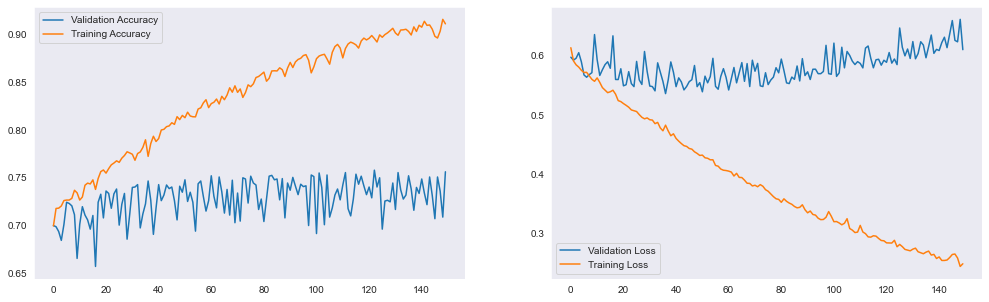

In [30]:
visualize_training_results(baseline_history)

In [31]:
baseline_train_results = baseline_model.evaluate(train_x, train_labels)

314/314 [==============================] - 1s 4ms/step - loss: 0.2287 - accuracy: 0.9224


In [32]:
baseline_val_results = baseline_model.evaluate(val_x, val_labels)

75/75 [==============================] - 0s 5ms/step - loss: 0.6103 - accuracy: 0.7562


In [33]:
baseline_test_results = baseline_model.evaluate(test_x, test_labels)

4/4 [==============================] - 0s 4ms/step - loss: 0.4179 - accuracy: 0.8080


              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71        46
         1.0       0.81      0.91      0.86        79

    accuracy                           0.81       125
   macro avg       0.81      0.77      0.78       125
weighted avg       0.81      0.81      0.80       125



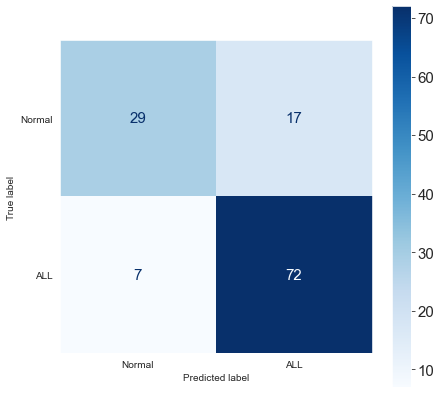

In [34]:
plot_confusion_matrix(baseline_model, test_labels, test_x)

### This model is over-fitting on the training data.        
> #### Our validation scores are not improving and there is no convergence.
> #### However, our test accuracy is not bad for a baseline at 81%

### **Recall is not good enough... 89%**         
> ### **We need to minimize false negatives and maximize correct positive diagnoses**

## Build a baseline Convolutional Neural Network

In [12]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/train',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size=10024)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/validation',
        classes={'Normal':0, 'ALL':1},
        class_mode='binary',
        batch_size = 2379)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/test',
        classes={'Normal':0, 'ALL':1},        
        class_mode='binary',
        batch_size = 125)


train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)


class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes
                                                 )

train_class_weights = dict(enumerate(class_weights))

Found 10024 images belonging to 2 classes.
Found 2379 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [13]:
# Instantiate the model and build it's layers
cnn1 = models.Sequential()

cnn1.add(layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(256,256,3)))
cnn1.add(layers.MaxPool2D(2,2))

cnn1.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn1.add(layers.MaxPool2D(2,2))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Compile the model
cnn1.compile(optimizer=RMSprop(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model
cnn1_history = cnn1.fit(train_images, train_labels,
                        epochs=30,
                        batch_size=100,
                        validation_data=(val_images, val_labels),
                        class_weight=train_class_weights)

Epoch 1/30
101/101 [==============================] - 196s 2s/step - loss: 0.6063 - accuracy: 0.7016 - val_loss: 0.5741 - val_accuracy: 0.7150
Epoch 2/30
101/101 [==============================] - 194s 2s/step - loss: 0.5808 - accuracy: 0.7207 - val_loss: 0.5689 - val_accuracy: 0.7209
Epoch 3/30
101/101 [==============================] - 193s 2s/step - loss: 0.5655 - accuracy: 0.7276 - val_loss: 0.5432 - val_accuracy: 0.7322
Epoch 4/30
101/101 [==============================] - 189s 2s/step - loss: 0.5517 - accuracy: 0.7341 - val_loss: 0.5384 - val_accuracy: 0.7461
Epoch 5/30
101/101 [==============================] - 191s 2s/step - loss: 0.5380 - accuracy: 0.7394 - val_loss: 0.5288 - val_accuracy: 0.7419
Epoch 6/30
101/101 [==============================] - 192s 2s/step - loss: 0.5319 - accuracy: 0.7461 - val_loss: 0.5394 - val_accuracy: 0.7385
Epoch 7/30
101/101 [==============================] - 190s 2s/step - loss: 0.5217 - accuracy: 0.7522 - val_loss: 0.5240 - val_accuracy: 0.7491

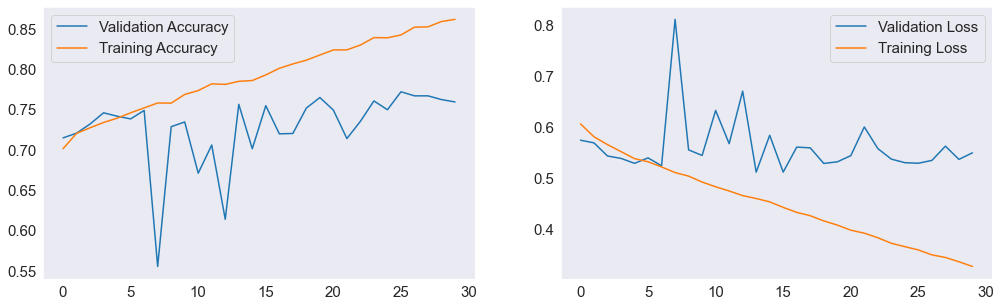

In [22]:
visualize_training_results(cnn1_history)

In [18]:
cnn1_train_results = cnn1.evaluate(train_images, train_labels)

314/314 [==============================] - 51s 162ms/step - loss: 0.2997 - accuracy: 0.8655


In [19]:
cnn1_val_results = cnn1.evaluate(val_images, val_labels)

75/75 [==============================] - 12s 165ms/step - loss: 0.5494 - accuracy: 0.7596


In [20]:
cnn1_test_results = cnn1.evaluate(test_images, test_labels)

4/4 [==============================] - 1s 180ms/step - loss: 0.4352 - accuracy: 0.7760


              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65        46
         1.0       0.78      0.90      0.84        79

    accuracy                           0.78       125
   macro avg       0.77      0.73      0.74       125
weighted avg       0.77      0.78      0.77       125



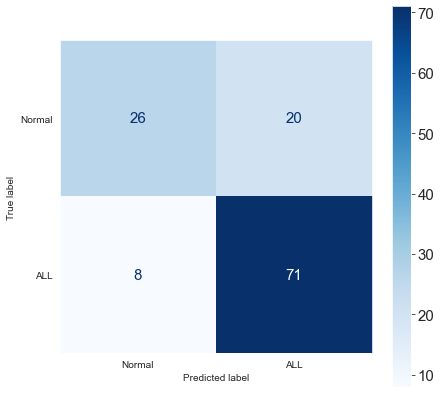

In [21]:
plot_confusion_matrix(cnn1, test_labels, test_images)

### This is worse than our baseline model using only dense layers, but at least we are not over fitting

### It also looks like we need more epochs as our accuracy kept improving and never tailed off

## Now we will build a CNN with more epochs and data augmentation which will hopefully provide a more robust model that will perform better on validation and test data

In [26]:
# Introduce data augmentation methods in our training data generator

train_generator = ImageDataGenerator(rescale=1./255, 
        rotation_range=180, fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,1.5]).flow_from_directory('data/tvt/train',
                                                        classes={'Normal':0, 'ALL':1},
                                                        class_mode='binary',
                                                        batch_size=10024)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                    'data/tvt/validation',
                                    classes={'Normal':0, 'ALL':1},
                                    class_mode='binary',
                                    batch_size = 2379)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                    'data/tvt/test',
                                    classes={'Normal':0, 'ALL':1},        
                                    class_mode='binary',
                                    batch_size = 125)


train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)


class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes
                                                 )

train_class_weights = dict(enumerate(class_weights))

Found 10024 images belonging to 2 classes.
Found 2379 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [27]:
# Instantiate the model and build it's layers
# We will add another CNN layer on this model

cnn_aug = models.Sequential()

cnn_aug.add(layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(256,256,3)))
cnn_aug.add(layers.MaxPool2D(2,2))

cnn_aug.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn_aug.add(layers.MaxPool2D(2,2))

cnn_aug.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
cnn_aug.add(layers.MaxPool2D(2,2))

cnn_aug.add(layers.Flatten())
cnn_aug.add(layers.Dense(64, activation='relu'))
cnn_aug.add(layers.Dense(1, activation='sigmoid'))

In [28]:
# Compile the model
cnn_aug.compile(optimizer=RMSprop(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model with more epochs
cnn_aug_history = cnn1.fit(train_images, train_labels,
                        epochs=80,
                        batch_size=100,
                        validation_data=(val_images, val_labels),
                        class_weight=train_class_weights)

Epoch 1/80
101/101 [==============================] - 204s 2s/step - loss: 0.7355 - accuracy: 0.6882 - val_loss: 0.6771 - val_accuracy: 0.5397
Epoch 2/80
101/101 [==============================] - 194s 2s/step - loss: 0.5704 - accuracy: 0.7239 - val_loss: 0.5687 - val_accuracy: 0.7272
Epoch 3/80
101/101 [==============================] - 192s 2s/step - loss: 0.5314 - accuracy: 0.7481 - val_loss: 0.6806 - val_accuracy: 0.5528
Epoch 4/80
101/101 [==============================] - 193s 2s/step - loss: 0.5097 - accuracy: 0.7648 - val_loss: 0.6699 - val_accuracy: 0.5948
Epoch 5/80
101/101 [==============================] - 192s 2s/step - loss: 0.4896 - accuracy: 0.7767 - val_loss: 0.5417 - val_accuracy: 0.7482
Epoch 6/80
101/101 [==============================] - 193s 2s/step - loss: 0.4751 - accuracy: 0.7806 - val_loss: 0.5924 - val_accuracy: 0.6751
Epoch 7/80
101/101 [==============================] - 192s 2s/step - loss: 0.4552 - accuracy: 0.7982 - val_loss: 0.5929 - val_accuracy: 0.6494

Epoch 58/80
101/101 [==============================] - 190s 2s/step - loss: 0.0704 - accuracy: 0.9818 - val_loss: 0.8446 - val_accuracy: 0.7339
Epoch 59/80
101/101 [==============================] - 189s 2s/step - loss: 0.0669 - accuracy: 0.9815 - val_loss: 0.8645 - val_accuracy: 0.7587
Epoch 60/80
101/101 [==============================] - 189s 2s/step - loss: 0.0698 - accuracy: 0.9808 - val_loss: 0.8449 - val_accuracy: 0.7520
Epoch 61/80
101/101 [==============================] - 189s 2s/step - loss: 0.0609 - accuracy: 0.9859 - val_loss: 0.8129 - val_accuracy: 0.7457
Epoch 62/80
101/101 [==============================] - 189s 2s/step - loss: 0.0566 - accuracy: 0.9881 - val_loss: 0.9063 - val_accuracy: 0.7604
Epoch 63/80
101/101 [==============================] - 189s 2s/step - loss: 0.0609 - accuracy: 0.9845 - val_loss: 0.8918 - val_accuracy: 0.7507
Epoch 64/80
101/101 [==============================] - 189s 2s/step - loss: 0.0582 - accuracy: 0.9845 - val_loss: 0.8749 - val_accuracy:

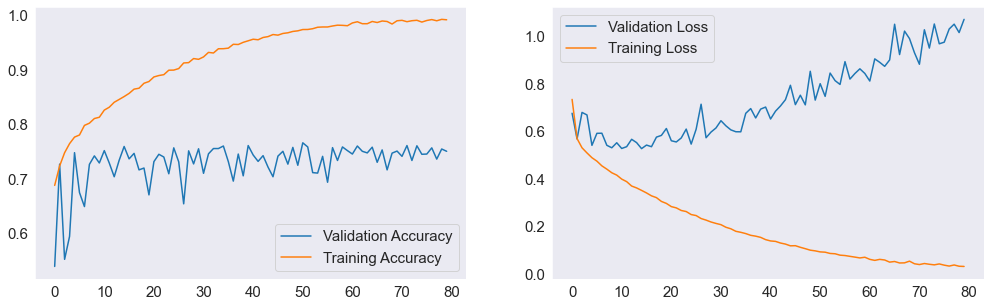

In [29]:
visualize_training_results(cnn_aug_history)

In [30]:
cnn_aug_train_results = cnn_aug.evaluate(train_images, train_labels)

314/314 [==============================] - 62s 198ms/step - loss: 0.6930 - accuracy: 0.5023


In [31]:
cnn_aug_val_results = cnn_aug.evaluate(val_images, val_labels)

75/75 [==============================] - 15s 197ms/step - loss: 0.6929 - accuracy: 0.4981


In [32]:
cnn_aug_test_results = cnn_aug.evaluate(test_images, test_labels)

4/4 [==============================] - 1s 200ms/step - loss: 0.6918 - accuracy: 0.5520


              precision    recall  f1-score   support

         0.0       0.36      0.28      0.32        46
         1.0       0.63      0.71      0.67        79

    accuracy                           0.55       125
   macro avg       0.50      0.50      0.49       125
weighted avg       0.53      0.55      0.54       125



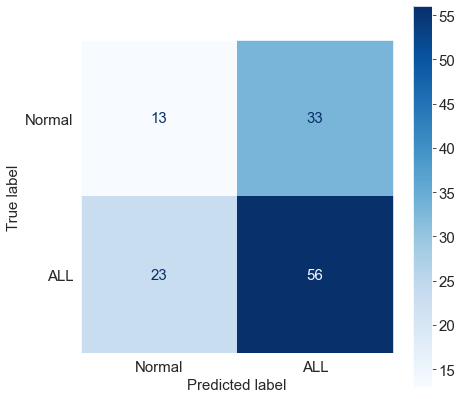

In [33]:
plot_confusion_matrix(cnn_aug, test_labels, test_images)